In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_2d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKANLayer, lmdKAN, importance_analyse_lmdKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


-----
-----
## $f_3(x_1, x_2, x_3, x_4)$

##### $f_3(x_1, x_2, x_3, x_4) = (\exp({a1} \cdot x_1) + \exp({a2} \cdot x_2) + {b1} \cdot \cos(\pi / 2 * x_1) + {b2} \cdot \cos(\pi / 2 * x_2) - 5) / 5$

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


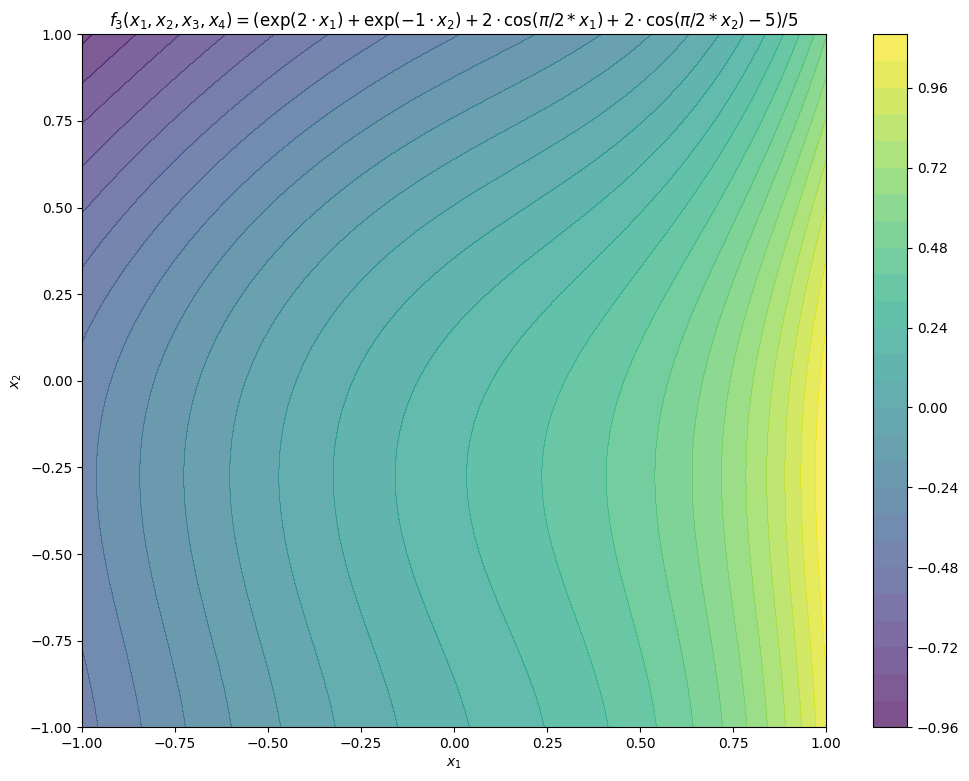

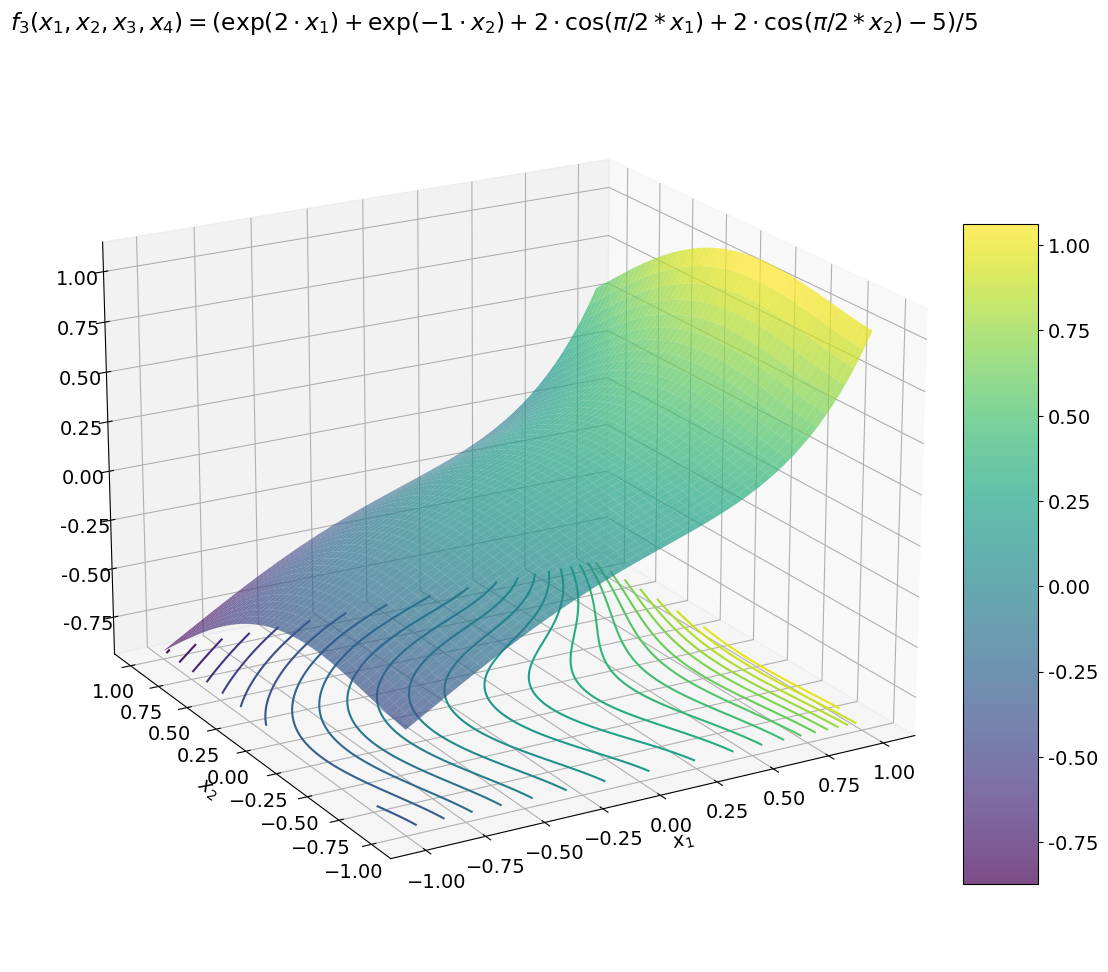

In [2]:
# create dataset
a1, a2, b1, b2 = 2, -1, 2, 2
f3 = lambda x: (torch.exp(a1*x[:,[0]]) + torch.exp(a2*x[:,[1]]) + b1*torch.cos(torch.pi/2*x[:,[0]]) + b2*torch.cos(torch.pi/2*x[:,[1]]) -5 ) / 5
dataset3 = create_dataset(f3, n_var=4, device=device)

f = f3
dataset = dataset3

plot_f_2d(f3, title=f'$f_3(x_1, x_2, x_3, x_4) = (\exp({a1} \cdot x_1) + \exp({a2} \cdot x_2) + {b1} \cdot \cos(\pi / 2 * x_1) + {b2} \cdot \cos(\pi / 2 * x_2) - 5) / 5$')
plot_f_3d(f3, title=f'$f_3(x_1, x_2, x_3, x_4) = (\exp({a1} \cdot x_1) + \exp({a2} \cdot x_2) + {b1} \cdot \cos(\pi / 2 * x_1) + {b2} \cdot \cos(\pi / 2 * x_2) - 5) / 5$')

-----
### MLP on $f_3$

№ model trainable params: 246


| train_loss: 2.61e-03 | test_loss: 2.80e-03 | reg: 6.80e+01 | : 100%|█| 100/100 [00:28<00:00,  3.51


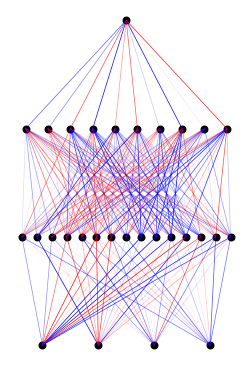

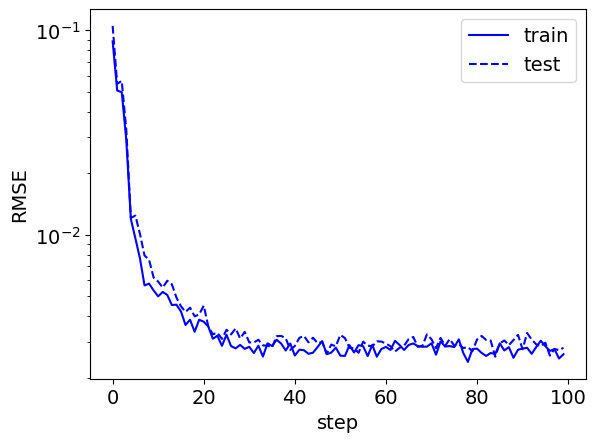

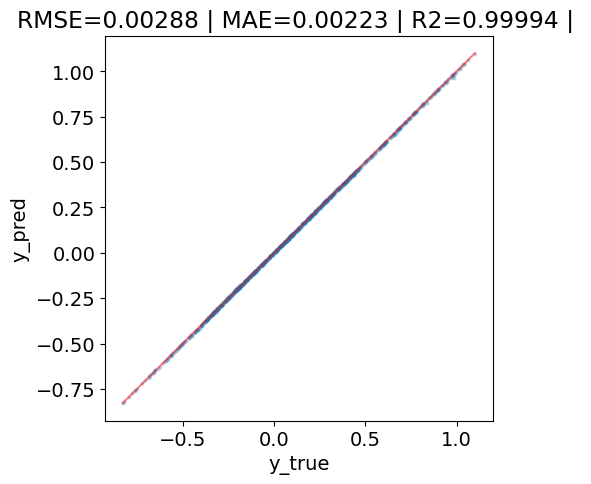

In [3]:
# initialize MLP
model = MLP(width=[4,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_3$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 300


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 1.66e-03 | test_loss: 1.75e-03 | reg: 5.75e+00 | : 100%|█| 100/100 [03:32<00:00,  2.12


saving model version 0.1


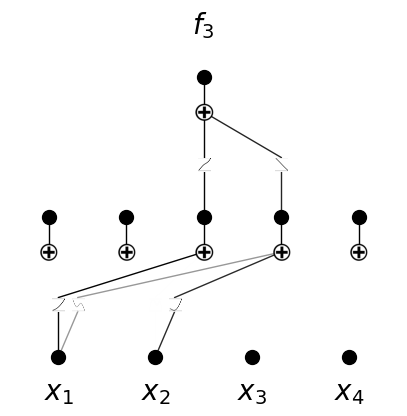

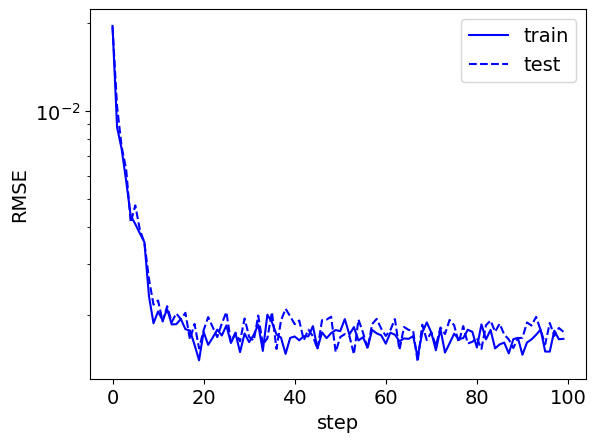

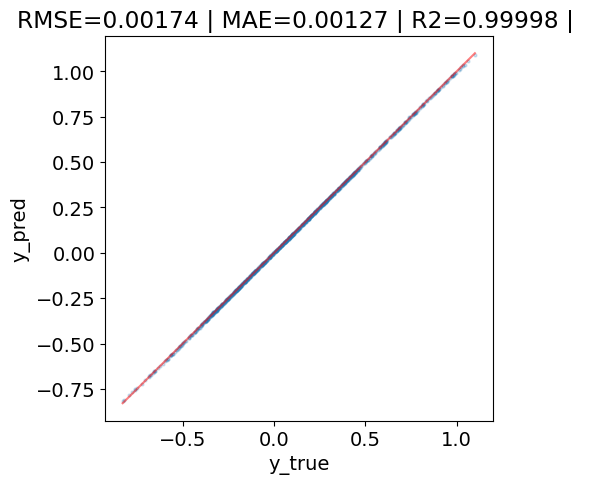

In [4]:
# initialize KAN with G=3
model = KAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_3$'])

-----
### $\lambda$-KAN on $f_3$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


| train_loss: 3.48e-02 | test_loss: 3.91e-02 | reg: 1.18e+01 | : 100%|█| 150/150 [01:03<00:00,  2.37


saving model version 0.1


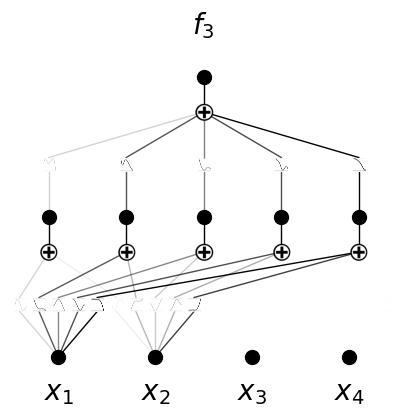

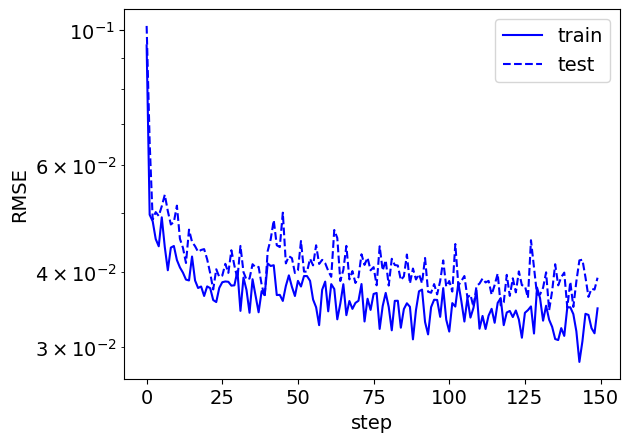

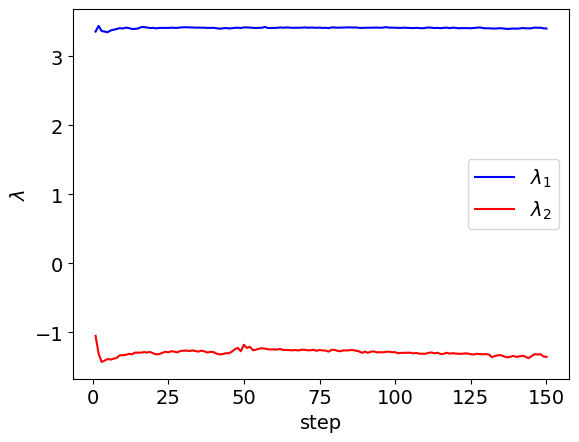

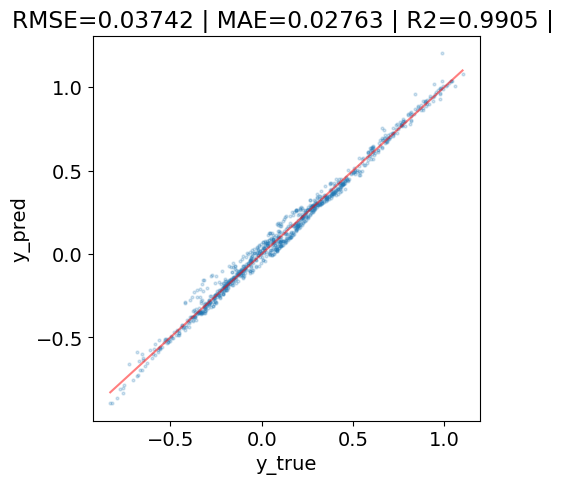

model.act_fun[0].lmd=Parameter containing:
tensor([ 3.4054e+00, -1.3564e+00, -1.2092e-04,  9.0209e-03],
       requires_grad=True)


In [6]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_3$'])
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:41, 21.24it/s]                          


module of Input importance:


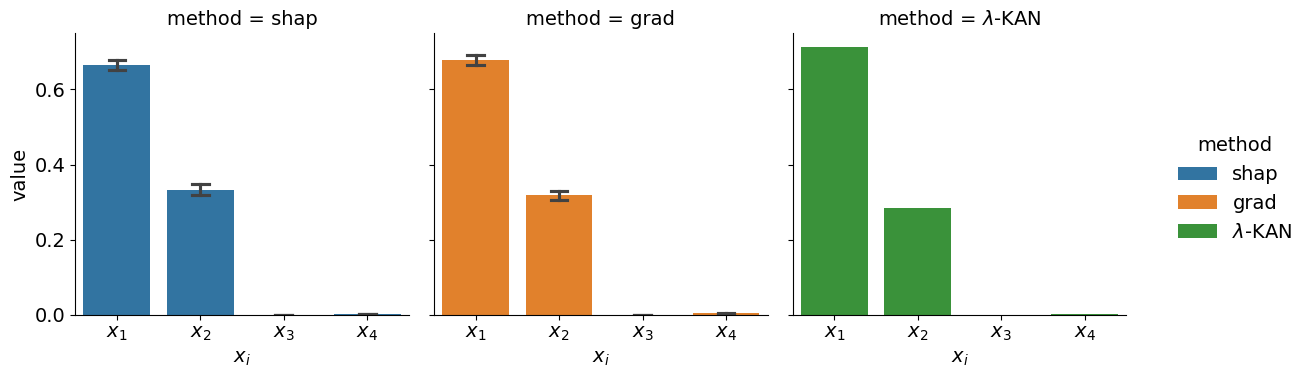

Input importance:


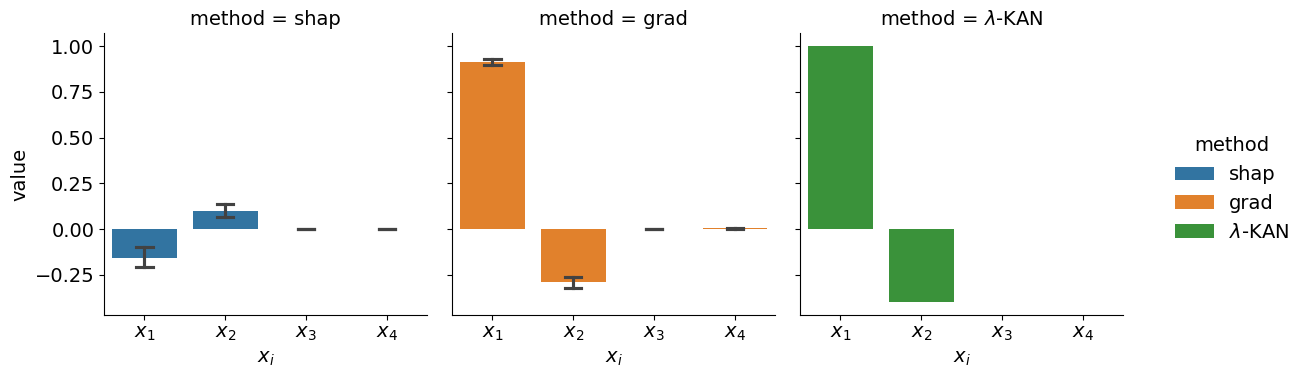

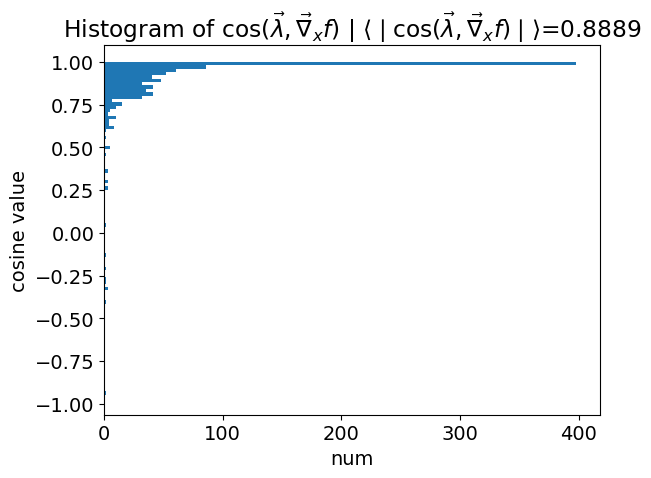

In [7]:
importance_analyse_lmdKAN(model, dataset)

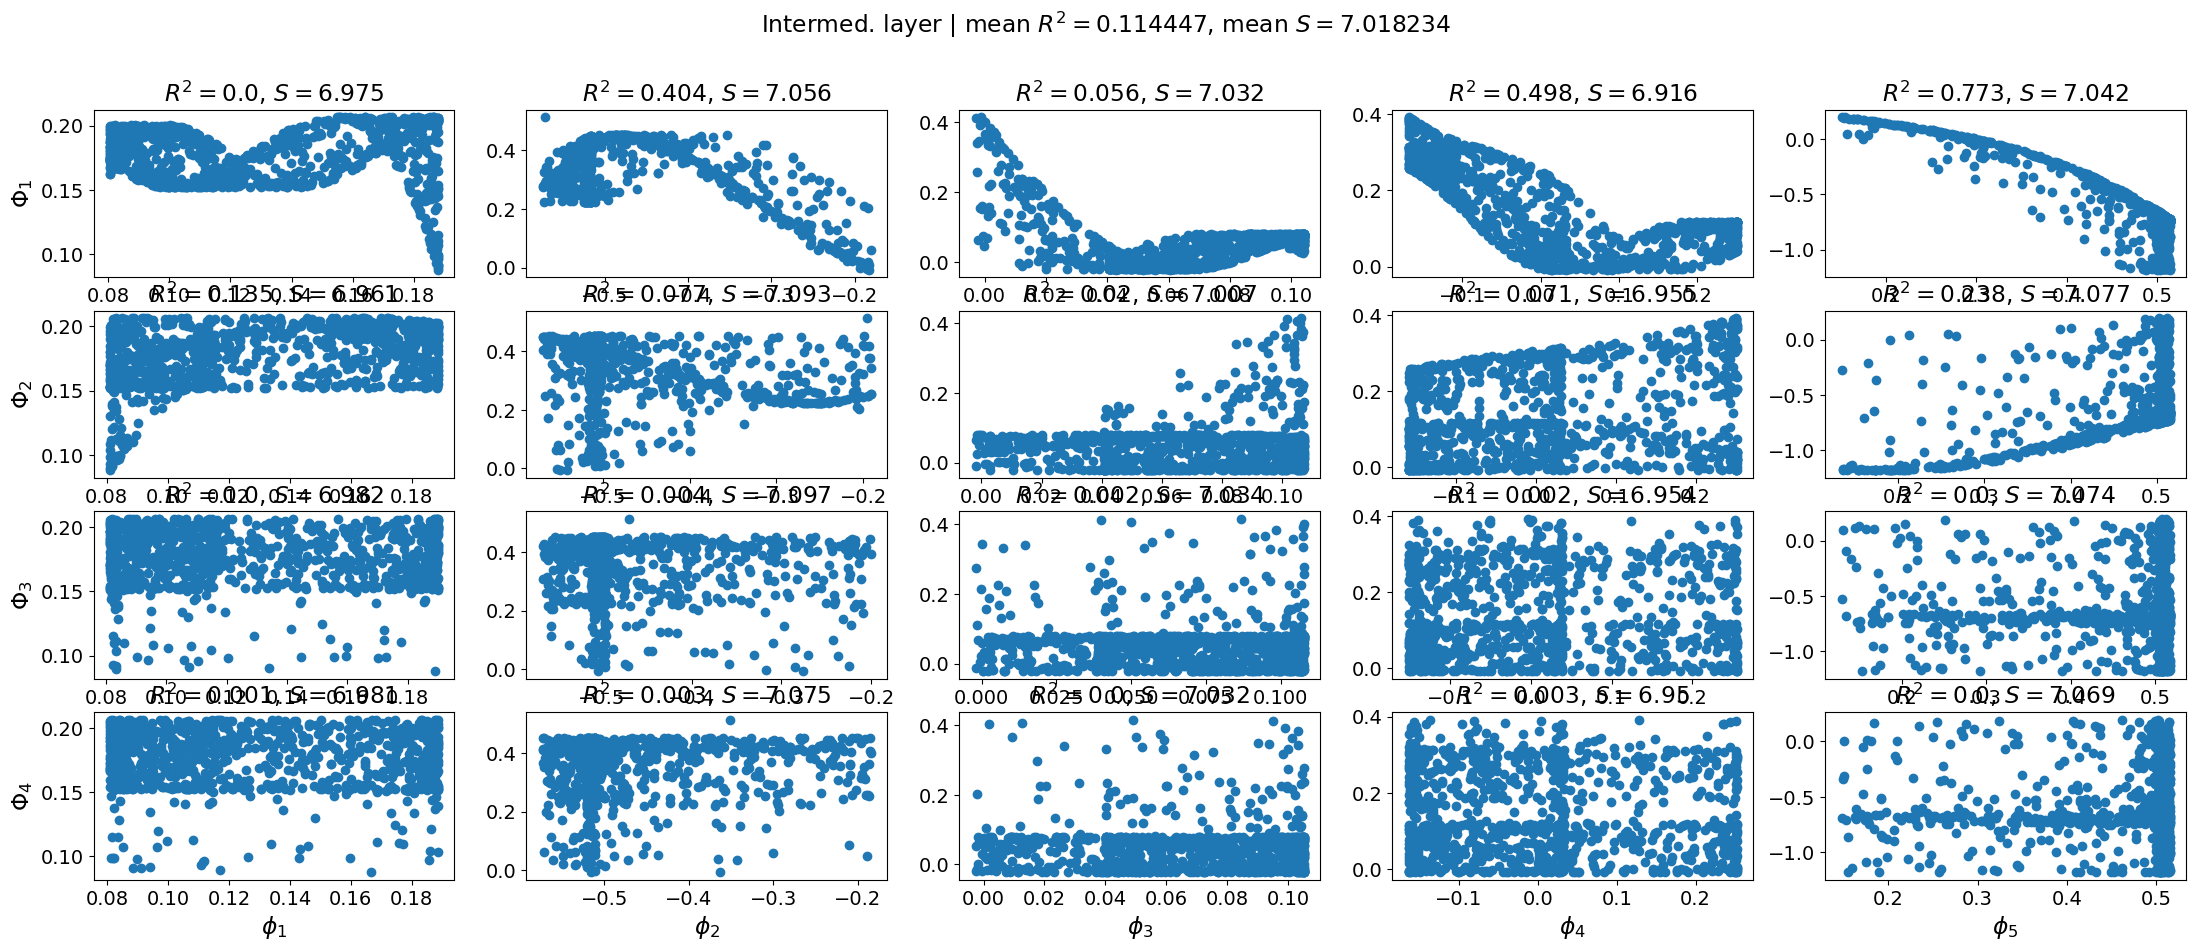

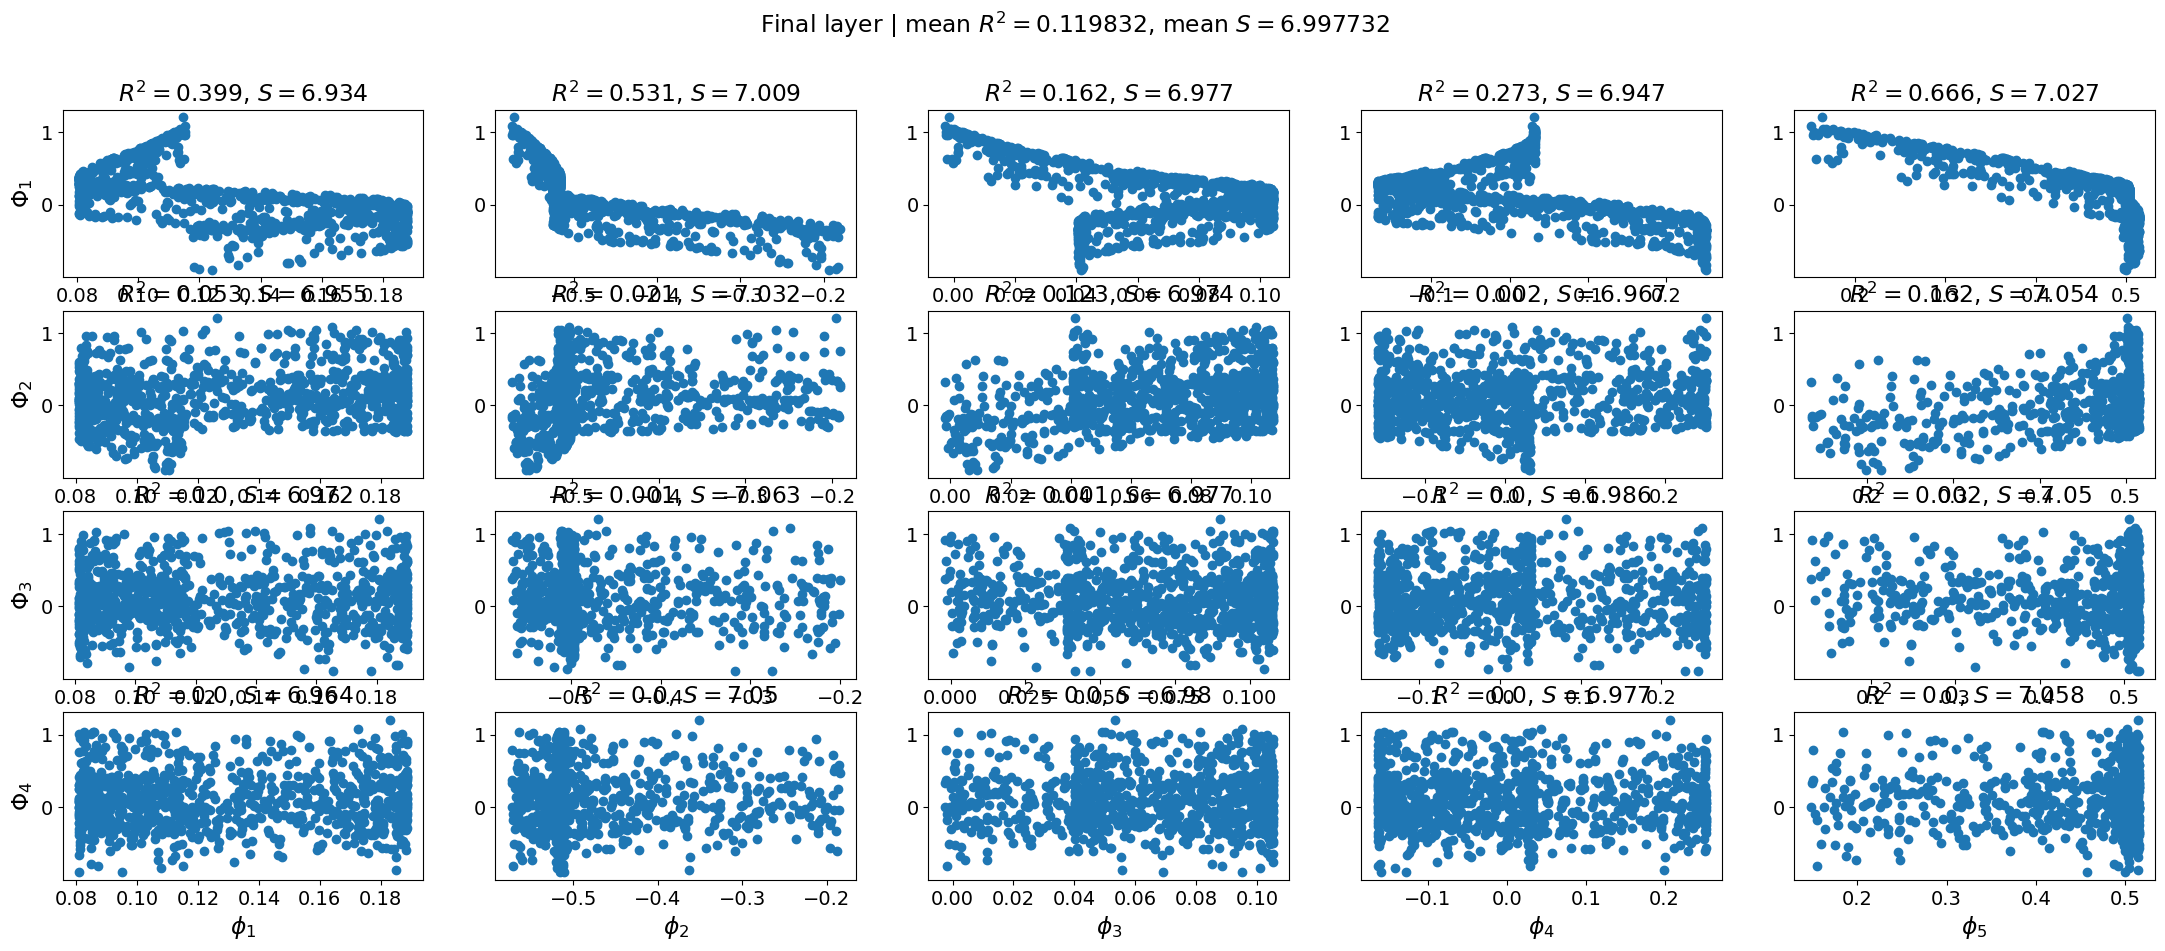

{'mean_r2': 0.11983238602613255, 'mean_matrix_entropy': 6.997731685638428}

In [8]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')


-----
-----
## $f_3(x_1, x_2, x_3, x_4)$

## $x_3, x_4$ - LC($x_3, x_4$) + normal random

##### $f_3(x_1, x_2, x_3, x_4) = (\exp({a1} \cdot x_1) + \exp({a2} \cdot x_2) + {b1} \cdot \cos(\pi / 2 * x_1) + {b2} \cdot \cos(\pi / 2 * x_2) - 5) / 5$

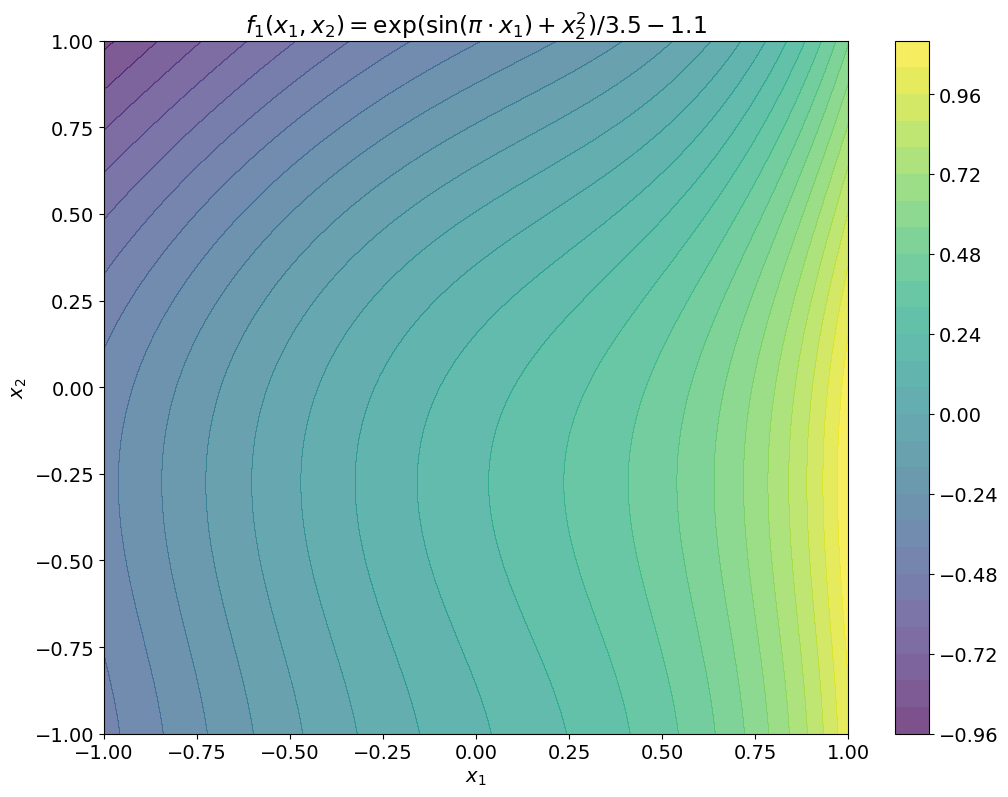

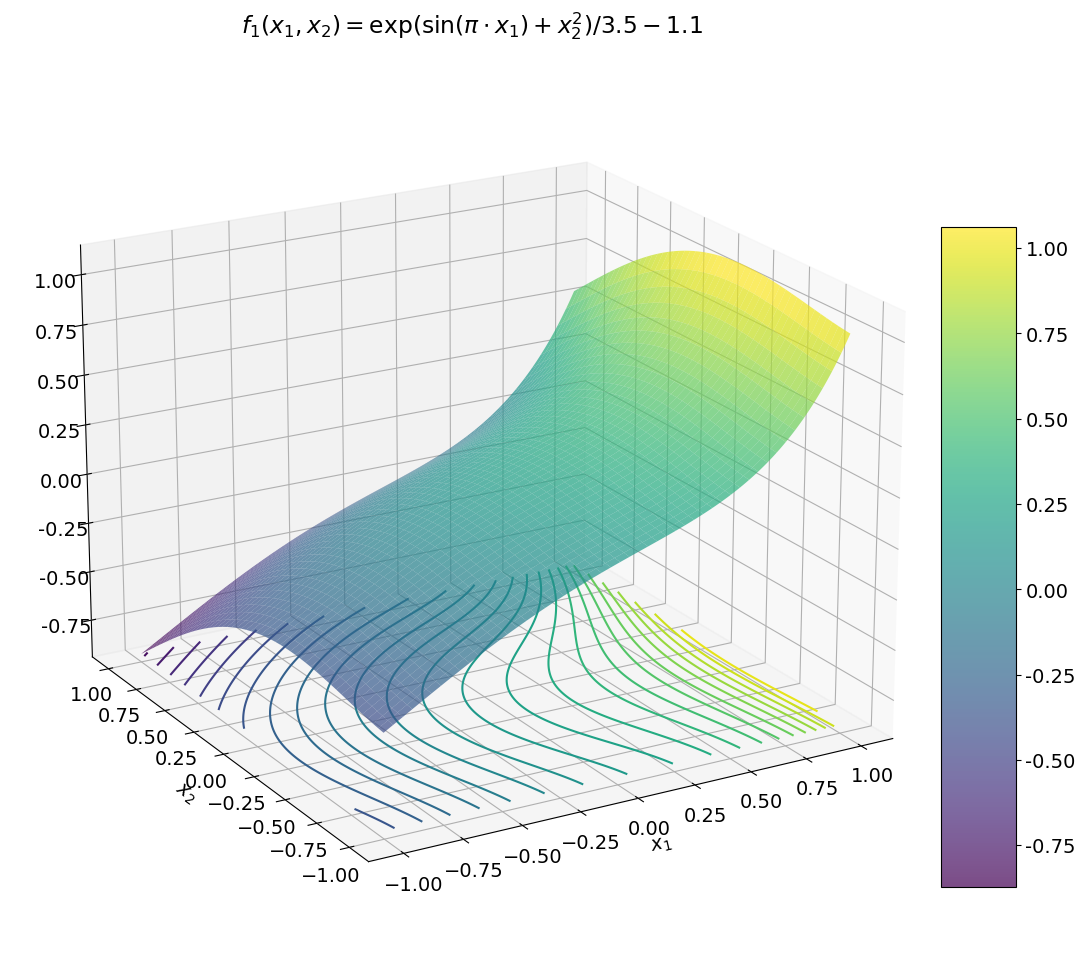

In [ ]:
# create dataset
a1, a2, b1, b2 = 2, -1, 2, 2
f3 = lambda x: (torch.exp(a1*x[:,[0]]) + torch.exp(a2*x[:,[1]]) + b1*torch.cos(torch.pi/2*x[:,[0]]) + b2*torch.cos(torch.pi/2*x[:,[1]]) -5 ) / 5
dataset3 = create_dataset(f3, n_var=2, device=device)

# adding new inputs
SNR = 20 #noize_ampl=1 with SNR=20
noize_ampl = 10**(-SNR/20)

add_x = torch.stack((2**(-0.5)*dataset3['train_input'][:,0] + 2**(-0.5)*dataset3['train_input'][:,1] + noize_ampl*torch.randn(*dataset3['train_input'][:,0].shape),
                     2**(-0.5)*dataset3['train_input'][:,0] - 2**(-0.5)*dataset3['train_input'][:,1] + noize_ampl*torch.randn(*dataset3['train_input'][:,0].shape))
                     , dim=1)
dataset3['train_input'] = torch.concat((dataset3['train_input'], add_x), dim=1)

add_x = torch.stack((2**(-0.5)*dataset3['test_input'][:,0] + 2**(-0.5)*dataset3['test_input'][:,1] + noize_ampl*torch.randn(*dataset3['test_input'][:,0].shape),
                     2**(-0.5)*dataset3['test_input'][:,0] - 2**(-0.5)*dataset3['test_input'][:,1] + noize_ampl*torch.randn(*dataset3['test_input'][:,0].shape)), 
                    dim=1)
dataset3['test_input'] = torch.concat((dataset3['test_input'], add_x), dim=1)

f = f3
dataset = dataset3

plot_f_2d(f3, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f3, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

-----
### MLP on $f_3$

№ model trainable params: 246


| train_loss: 1.70e-03 | test_loss: 1.61e-03 | reg: 7.18e+01 | : 100%|█| 100/100 [00:07<00:00, 13.39


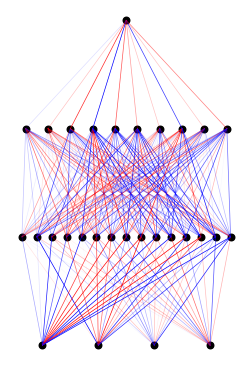

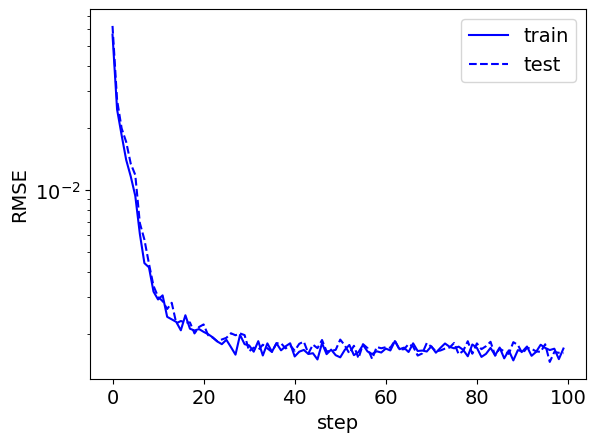

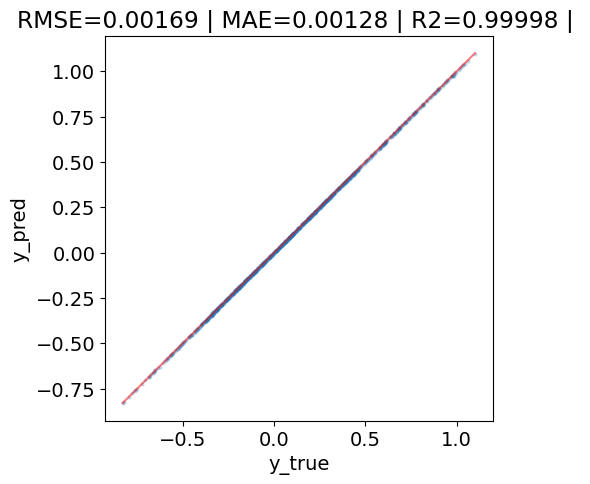

In [ ]:
# initialize MLP
model = MLP(width=[4,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_3$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 300


| train_loss: 9.39e-04 | test_loss: 9.07e-04 | reg: 5.60e+00 | : 100%|█| 100/100 [00:35<00:00,  2.83


saving model version 0.1


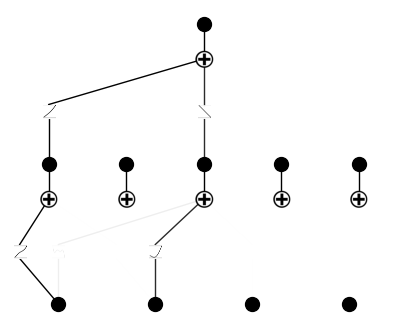

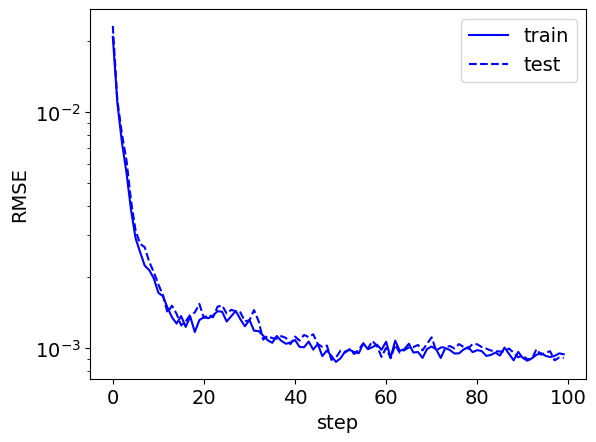

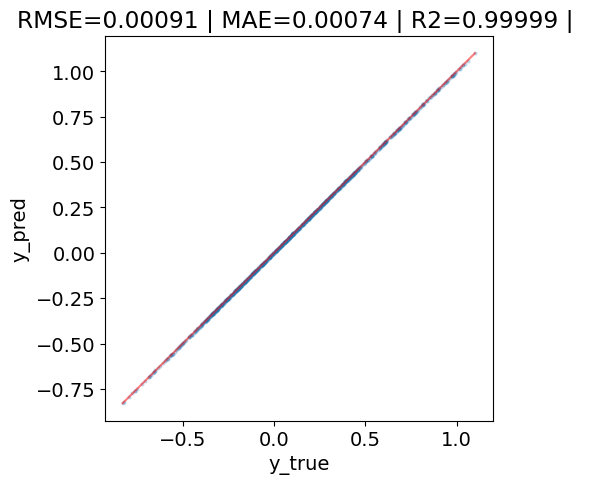

In [ ]:
# initialize KAN with G=3
model = KAN(width=[4,5,1], grid=3, k=3, seed=2, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_3$'])

-----
### $\lambda$-KAN on $f_3$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


| train_loss: 2.47e-02 | test_loss: 2.76e-02 | reg: 1.16e+01 | : 100%|█| 150/150 [00:38<00:00,  3.86


saving model version 0.1


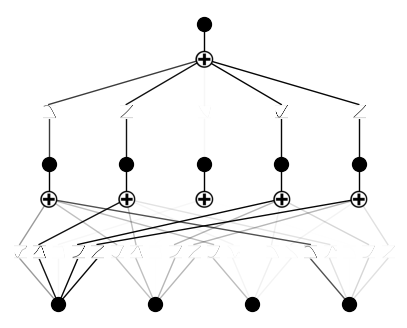

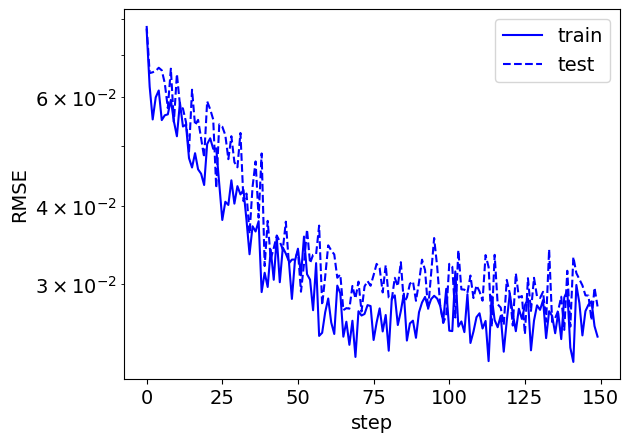

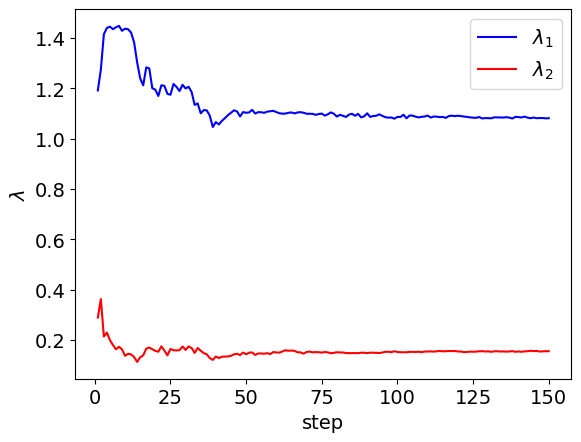

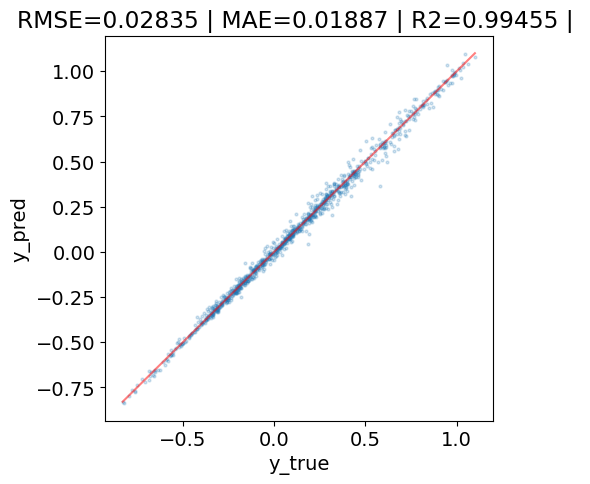

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.0812,  0.1556, -0.0281,  0.0704], requires_grad=True)


In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=5, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_3$'])
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:27, 21.51it/s]                          


module of Input importance:


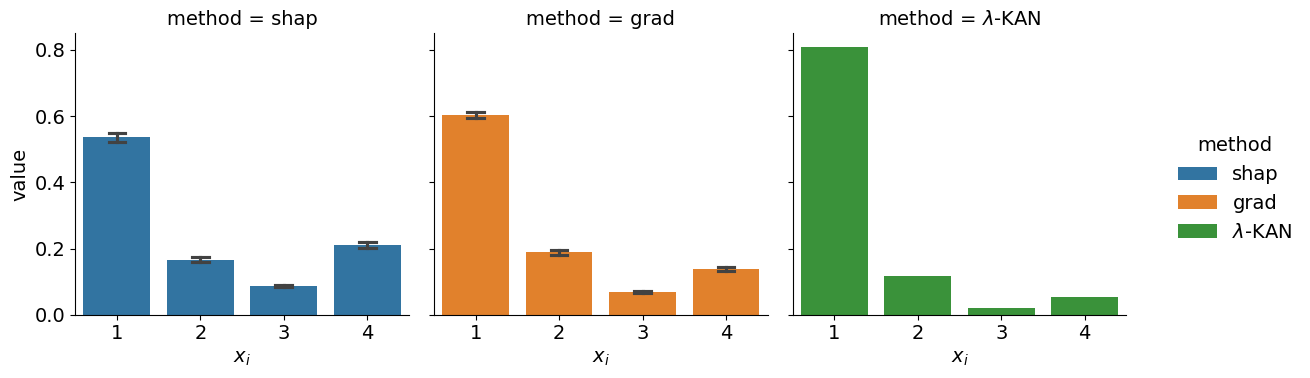

Input importance:


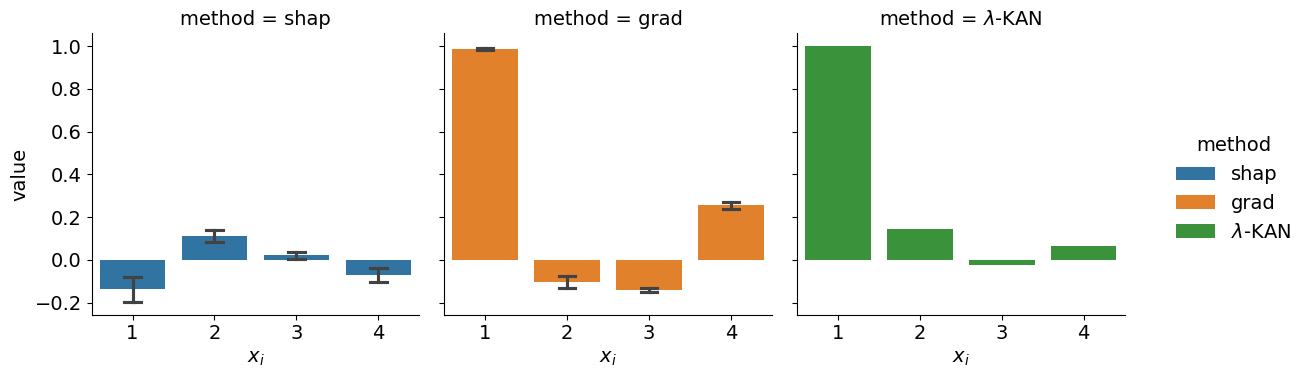

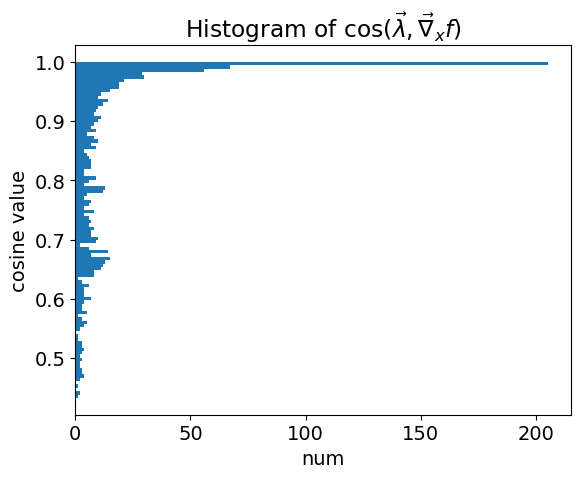

In [ ]:
importance_analyse_lmdKAN(model, dataset)

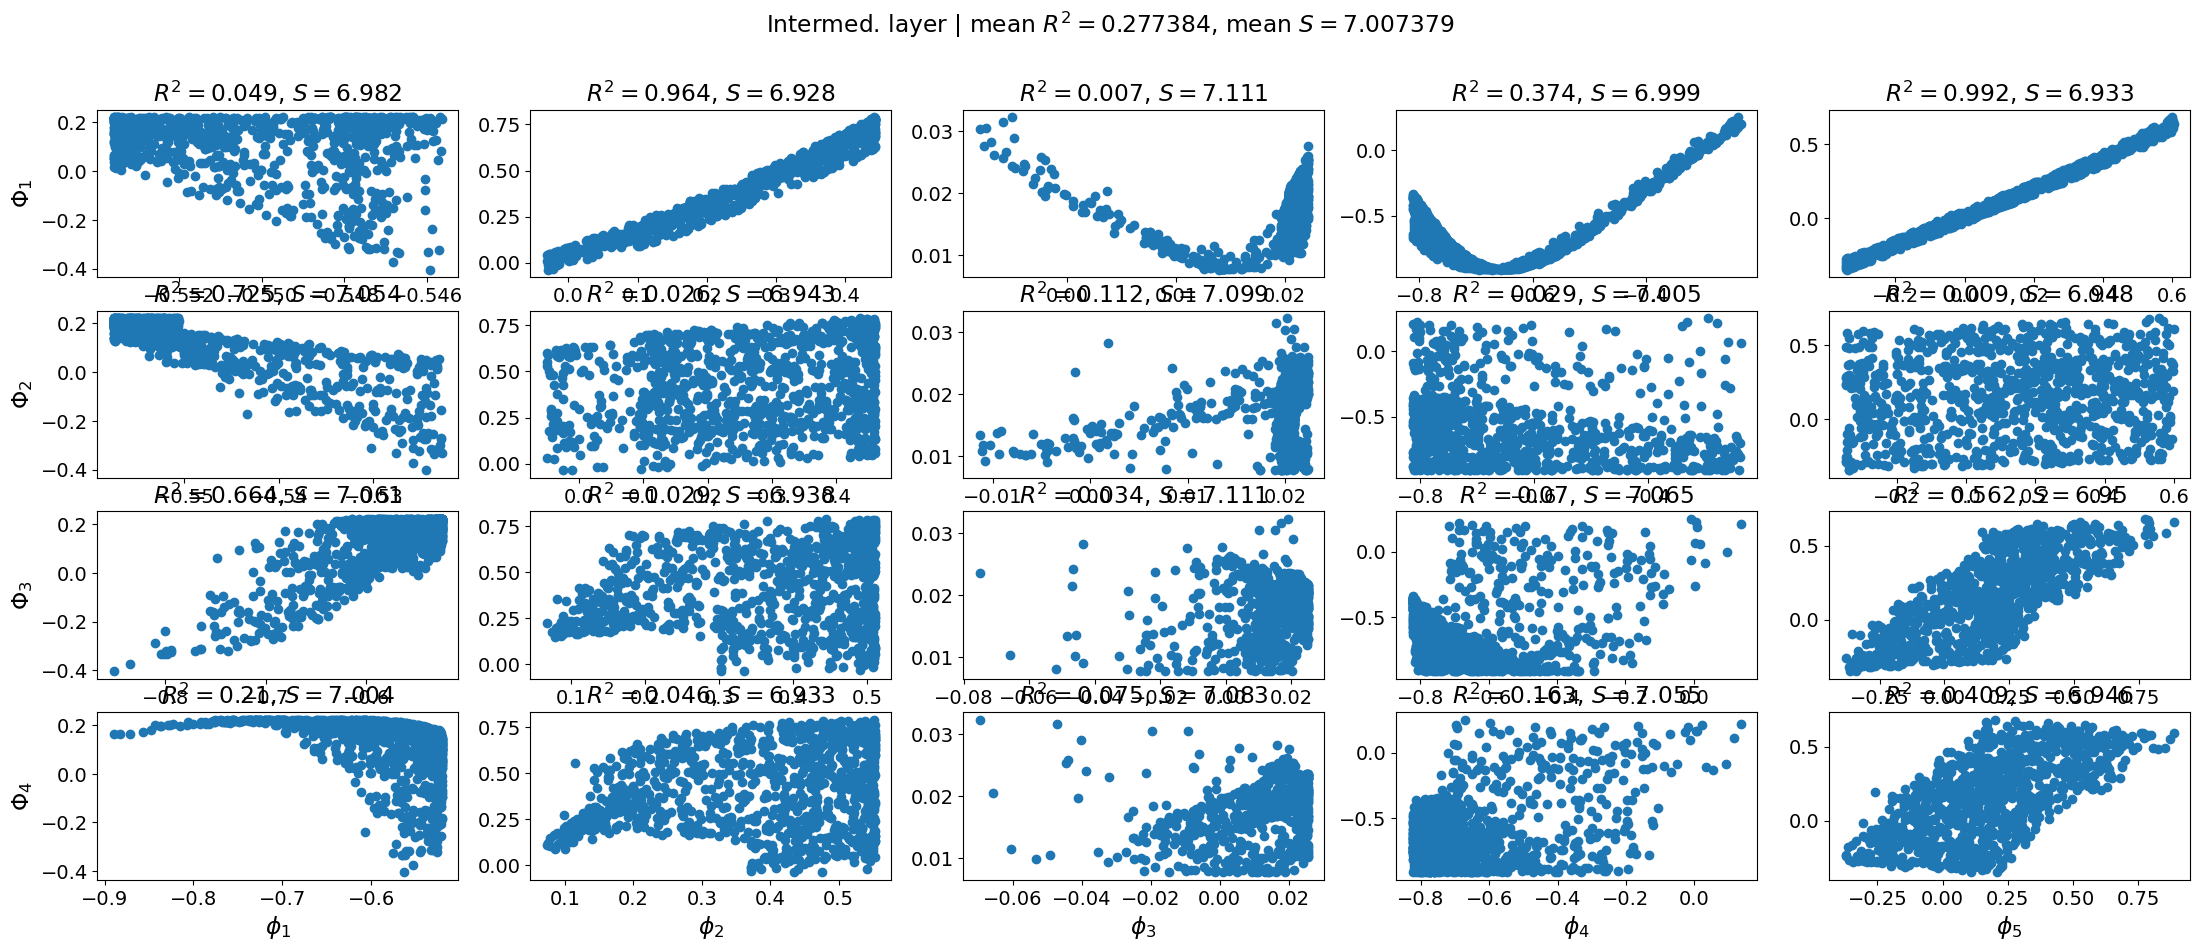

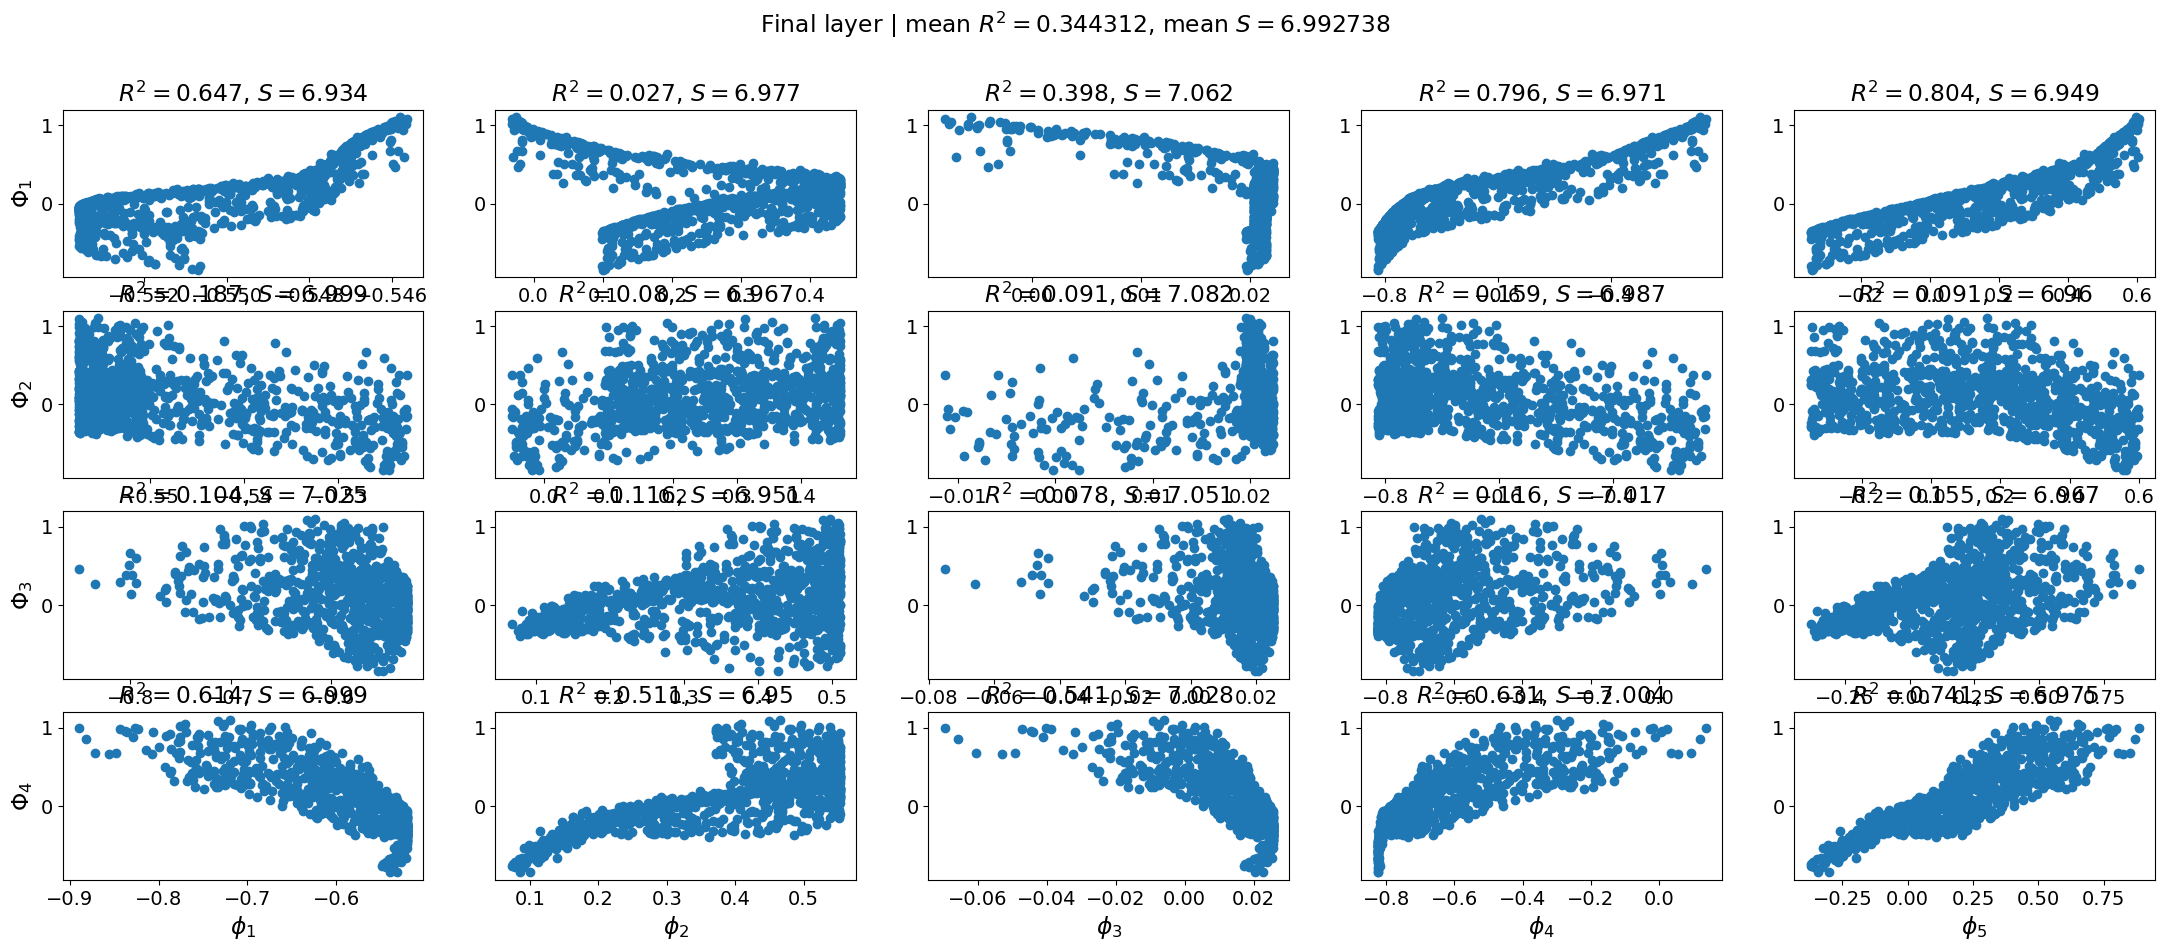

{'mean_r2': 0.34431181540712713, 'mean_matrix_entropy': 6.992738246917725}

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')